In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def extract_color(img, lower_color, upper_color):
    blur = cv2.blur(img,(10,10))
    hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)

    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_color, upper_color)
    return mask

In [4]:
# http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
# opening処理をすることでノイズ除去
def noise_removal(mask):
    kernel = np.ones((5,5),np.uint8)
    #kernel = np.ones((1,1),np.uint8)
    erosion = cv2.erode(mask,kernel,iterations = 1)
    return erosion

In [5]:
# エッジ抽出
def extract_edge(erosion):
    edges = cv2.Canny(erosion,150,250)
    return(edges)

In [7]:
def each_vars(area_pos):
    x_max = np.max(area_pos[:, 0])
    x_min = np.min(area_pos[:, 0])
    x_range = x_max - x_min
    #上中下、各部分の分散をx_varに格納
    x_var = [0,0,0]
    for i in range(0,3):
        if i == 0:
            x_th_min = 0
        else:
            x_th_min = x_min + (x_range*(i))/3.0
        x_th_max = x_min + (x_range*(i+1))/3.0
        index1 = np.where(area_pos[:, 0] > x_th_min)
        index2 = np.where(area_pos[index1][:, 0] < x_th_max)
        if i == 0:
            x_var[0] = np.var(area_pos[index2][:, 1])
        if i == 1:
            x_var[1] = np.var(area_pos[index2][:, 1])
        if i == 2:
            x_var[2] = np.var(area_pos[index2][:, 1])
    return x_var

In [8]:
# 上中下の各分散から巻き取るべきところを調べる
def choose_direction(x_var):
    top = x_var[0]
    mid = x_var[1]
    btm = x_var[2]
    if (top >= mid) and (top >= btm):
        str = "down!"
    elif (mid >= top) and (mid >= btm):
        if (top >= btm):
            str = "down!"
        else:
            str = "up!"
    else:
        str = "up!"
    return str

In [10]:
def fitting_line(erosion):
    imgEdge,contours,hierarchy = cv2.findContours(erosion, 1, 2)
    if len(contours) == 0:
        slope = 1
        intercept = 1
        righty = 1
    else:
        cnt = contours[0]

        rows,cols = erosion.shape[:2]
        [vx,vy,x,y] = cv2.fitLine(cnt, cv2.DIST_L2,0,0.01,0.01)
        lefty = int((-x*vy/vx) + y)
        righty = int(((cols-x)*vy/vx)+y)
        #img = cv2.line(img,(cols-1,righty),(0,lefty),(0,255,0),2)

        #傾き
        slope = vy/vx

        #y切片
        intercept = lefty
        return([slope, intercept, righty, cols])

[0.009563256435227705, 0.006082007704447211, 0.0009616101736733579]
down!


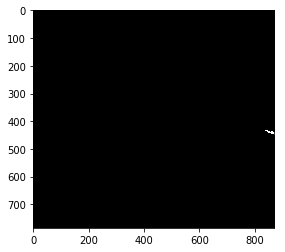

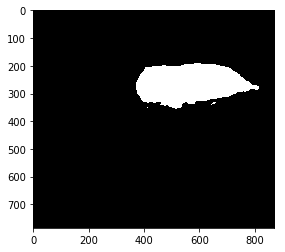

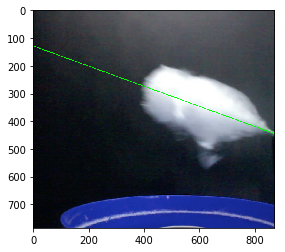

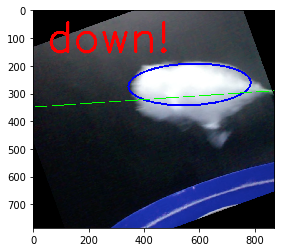

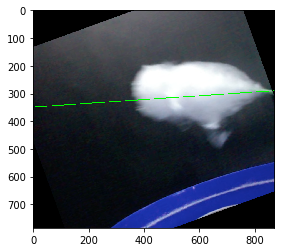

In [12]:
img = cv2.imread('figures/test_image.png')

#白検出
lower_white = np.array([0,0,180])
upper_white = np.array([180,30,255])

#養生検出
lower_green = np.array([30,50,100])
upper_green = np.array([130,255,255])


mask_green1 = extract_color(img, lower_green, upper_green)
erosion_green1 = noise_removal(mask_green1)
#養生フィッティング
'''
    polyfitなどの通常のフィッティングでは対応できないのでopencvの関数を使用
'''
slope1 = fitting_line(erosion_green1)[0]
lefty1 = fitting_line(erosion_green1)[1]
righty1 = fitting_line(erosion_green1)[2]

'''
    つまり養生をフィッティングした直線は
    y = slope * x + intercept
    slope * x + (-1) * y + intercept = 0
'''

img_rows = img.shape[0]
img_cols = img.shape[1]

#画像の回転
theta = np.rad2deg(np.arctan(slope1)) # 回転角
scale = 1.0    # 回転角度・拡大率

M = cv2.getRotationMatrix2D((img_cols/2,img_rows/2),theta,scale)
dst = cv2.warpAffine(img,M,(img_cols,img_rows))
dst2 = cv2.warpAffine(img,M,(img_cols,img_rows))

#再びフィッティング
mask_green2 = extract_color(dst, lower_green, upper_green)
erosion_green2 = noise_removal(mask_green2)

#養生フィッティング2
slope2 = fitting_line(erosion_green2)[0]
lefty = fitting_line(erosion_green2)[1]
righty = fitting_line(erosion_green2)[2]

#白色の領域を抽出
mask_white = extract_color(dst, lower_white, upper_white)
erosion_white = noise_removal(mask_white)
white_area = np.where(erosion_white > 0)

#白色の領域の座標
white_area_pos = np.vstack([white_area[1], white_area[0]])

#わたあめを包含する図形を描画したい！
imgEdge,contours,hierarchy = cv2.findContours(erosion_white, 1, 2)

for i in range(len(contours)):
    cnt = contours[2]
    ellipse = cv2.fitEllipse(cnt)
    dst = cv2.ellipse(dst,ellipse,(0,0,255),5)

#点と直線の距離の公式から養生フィッティング直線からの距離を求める
distance = np.abs(slope2 * white_area[1] + (-1) * white_area[0] + lefty) / np.sqrt(slope2 ** 2 + lefty ** 2)

#white_area[0]はy座標
#距離とその時のx座標を紐付ける
white_distance = np.vstack([white_area[1], distance])

#上中下に分けて分散を計算
x_vars = each_vars(white_distance.T)
print(x_vars)

#それぞれの分散から巻き取るべき方向を指示
direction = choose_direction(x_vars)
print(direction)


if (righty < 10000) and (lefty < 10000):
    #養生フィッティングした線をひく
    dst = cv2.line(dst,(img_cols-1,righty),(0,lefty),(0,255,0),2)
    dst2 = cv2.line(dst2,(img_cols-1,righty),(0,lefty),(0,255,0),2)
    img = cv2.line(img,(img_cols-1,righty1),(0,lefty1),(0,255,0),2)

#plt.subplot(2, 2, 1)
plt.imshow(erosion_green1)
plt.gray()
plt.savefig("./figures/erosion_green1")
plt.show()

#plt.subplot(2, 2, 2)
plt.imshow(erosion_white)
plt.savefig("./figures/erosion_white")
plt.show()

#plt.subplot(2, 2, 3)
plt.imshow(img)
plt.savefig("./figures/img")
plt.show()

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(dst, direction, (50,150), font, 5,(255,0,0),10,cv2.LINE_AA)
#plt.subplot(2, 2, 4)
plt.imshow(dst)
plt.savefig("./figures/dst")
plt.show()

plt.imshow(dst2)
plt.savefig("./figures/dst2")
plt.show()

In [13]:
input_video = "video/test_video.avi"
#input_video = 0

cap = cv2.VideoCapture(input_video)
#cap = cv2.VideoCapture(0)

#動画保存するための準備
#fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,480))

if (input_video == 0) or (input_video == 1):
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))

#白検出
#lower_white = np.array([0,0,50])
lower_white = np.array([0,0,30])
upper_white = np.array([180,30,255])

#養生検出
lower_green = np.array([30,50,60])
upper_green = np.array([130,255,255])

cv2.startWindowThread()
while(cap.isOpened()):
    ret, img = cap.read()
    print(ret)
    
    if ret == True:
        #out.write(img)
        mask_green1 = extract_color(img, lower_green, upper_green)
        erosion_green1 = noise_removal(mask_green1)
        if np.all(erosion_green1 < 1):
            direction = "wakannyai"
        else:
            #養生フィッティング
            slope1 = fitting_line(erosion_green1)[0]
            lefty1 = fitting_line(erosion_green1)[1]
            righty1 = fitting_line(erosion_green1)[2]
            cols = fitting_line(erosion_green1)[3]
            dst = img.copy()
            dst_white = img.copy()

            img_rows = img.shape[0]
            img_cols = img.shape[1]

            #画像の回転
            theta = np.rad2deg(np.arctan(slope1)) # 回転角
            scale = 1.0    # 回転角度・拡大率

            M = cv2.getRotationMatrix2D((img_cols/2,img_rows/2),theta,scale)
            if (righty1 < cols) and (lefty1 < cols):
                dst = cv2.line(dst,(cols-1,righty1),(0,lefty1),(0,255,0),2)
            dst = cv2.warpAffine(dst,M,(img_cols,img_rows))
            dst_white = cv2.warpAffine(dst_white,M,(img_cols,img_rows))
            
            #再びフィッティング
            mask_green2 = extract_color(dst_white, lower_green, upper_green)
            erosion_green2 = noise_removal(mask_green2)
            if np.all(erosion_green2 < 1):
                direction = "wakannyai"
            else:
                #養生フィッティング2
                slope2 = fitting_line(erosion_green2)[0]
                lefty2 = fitting_line(erosion_green2)[1]
                righty2 = fitting_line(erosion_green2)[2]

                #白色の領域を抽出
                mask_white = extract_color(dst_white, lower_white, upper_white)
                erosion_white = noise_removal(mask_white)
                
                #if (righty1 < cols) and (lefty1 < cols):
                    #dst = cv2.line(dst,(cols-1,righty1),(0,lefty1),(0,255,0),2)
                
                if np.all(erosion_white < 1):
                    direction = "wakannyai"
                else:
                    imgEdge,contours,hierarchy = cv2.findContours(erosion_white, 1, 2)

                    for i in range(len(contours)):
                        cnt = contours[i]
                        (x,y),radius = cv2.minEnclosingCircle(cnt)
                        center = (int(x),int(y))
                        radius = int(radius)
                        dst = cv2.circle(dst,center,radius,(255,0,0),2)

                    white_area = np.where(erosion_white > 0)

                    #白色の領域の座標
                    white_area_pos = np.vstack([white_area[1], white_area[0]])

                    #点と直線の距離の公式から養生フィッティング直線からの距離を求める
                    distance = np.abs(slope2 * white_area[1] + (-1) * white_area[0] + lefty2) / np.sqrt(slope2 ** 2 + lefty ** 2)

                    #white_area[0]はy座標
                    #距離とその時のx座標を紐付ける
                    white_distance = np.vstack([white_area[1], distance])

                    #上中下に分けて分散を計算
                    x_vars = each_vars(white_distance.T)

                    #それぞれの分散から巻き取るべき方向を指示
                    direction = choose_direction(x_vars)
                    print(direction)

                    #養生フィッティングした線をひく
                    #if (righty2 < cols) and (lefty2 < cols):
                        #dst = cv2.line(dst,(cols-1,righty2),(0,lefty2),(0,255,0),2)

        if len(img.shape) == 3:
            height, width, channels = img.shape[:3]
        else:
            height, width = img.shape[:2]
            channels = 1

        #img_white = cv2.bitwise_and(img, img, mask=erosion_white)
        #img_green = cv2.bitwise_and(img, img, mask=erosion_green1)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, direction, (50,100), font, 3,(0,0,255),2,cv2.LINE_AA)
        cv2.imshow('direction', img)
        cv2.imshow('green', erosion_green1)
        cv2.imshow('white', erosion_white)
        cv2.imshow('dst', dst)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        print("aa")
        break
cap.release()
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

True
True
True
True
True
True
True
down!
True
True
True
down!
True
True
True
True
down!
True
True
down!
True
True
True
True
down!
True
down!
True
up!
True
True
True
True
True
down!
True
True
True
down!
True
up!
True
down!
True
True
True
True
down!
True
True
True
True
down!
True
True
True
True
True
down!
True
True
down!
True
True
True
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!
True
down!


-1